In [1]:
import os
import scanpy as sc
import scirpy as ir
import muon as mu
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt, cm as mpl_cm
import sys
from pathlib import Path
from scipy.stats import chisquare
import random

sys.path.insert(0, '/mnt/efs/hdiao/Projects/Tools')
import sc_tl

%matplotlib inline

sc.set_figure_params(frameon=False, figsize=(4, 4))
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.9.3 pandas==1.5.2 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.10.2 louvain==0.7.1 pynndescent==0.5.8


## Read input

In [2]:
sp_name = "T"

data_dir = "/mnt/efs/hdiao/Projects/BNT162v4_scRNA/0_cellranger_out"

in_dir = "/mnt/efs/hdiao/Projects/BNT162v4_scRNA/1_scanpy_scirpy/1_%s"%sp_name
sp_h5ad = "%s/%s.h5ad"%(in_dir, sp_name)

adata = sc.read_h5ad(sp_h5ad)

ir.tl.chain_qc(adata)
adata = adata[adata.obs['has_ir'] == 'True']
adata = adata[adata.obs['chain_pairing'] == 'single pair']

In [3]:
i_sp_dict = {}
for i in range(100):
    ###----- Random sampling
    use_index_g7 = random.sample(adata.obs[adata.obs['group'] == 'T_multi_G7'].index.tolist(), 1599)
    use_index_g9 = random.sample(adata.obs[adata.obs['group'] == 'T_multi_G9'].index.tolist(), 1599)
    use_index_g12 = random.sample(adata.obs[adata.obs['group'] == 'T_multi_G12'].index.tolist(), 1599)
    use_index = use_index_g7 + use_index_g9 + use_index_g12
    i_sp_dict[i] = use_index

In [4]:
g7_vs_g9_t, g7_vs_g9_p = [], []
g7_vs_g12_t, g7_vs_g12_p = [], []
g9_vs_g12_t, g9_vs_g12_p = [], []
for i in range(100):
    adata_flt = adata.copy()
    use_index = i_sp_dict[i]
    adata_flt = adata_flt[[True if x in use_index else False for x in adata_flt.obs.index]]

    ###----- Calculate clonal expansion
    ir.pp.ir_dist(adata_flt)
    ir.tl.define_clonotypes(adata_flt, receptor_arms="all", dual_ir="primary_only")
    ir.tl.clonotype_network(adata_flt, min_cells=5)
    ir.tl.clonal_expansion(adata_flt)


    ###----- Statistical test
    adata_flt.obs['expansion>=4'] = ['yes' if x >=4 else 'no' for x in adata_flt.obs['clone_id_size']]
    clone_4_sum_df = adata_flt.obs.reset_index()[['index', 'group','expansion>=4']].\
                     groupby(['group','expansion>=4']).count().reset_index()
    clone_4_sum_df = clone_4_sum_df.pivot(index='group', columns='expansion>=4', values='index')

    g7_vs_g9_t.append(chisquare(clone_4_sum_df.loc['T_multi_G7'], clone_4_sum_df.loc['T_multi_G9']).statistic)
    g7_vs_g12_t.append(chisquare(clone_4_sum_df.loc['T_multi_G7'], clone_4_sum_df.loc['T_multi_G12']).statistic)
    g9_vs_g12_t.append(chisquare(clone_4_sum_df.loc['T_multi_G9'], clone_4_sum_df.loc['T_multi_G12']).statistic)
    
    g7_vs_g9_p.append(chisquare(clone_4_sum_df.loc['T_multi_G7'], clone_4_sum_df.loc['T_multi_G9']).pvalue)
    g7_vs_g12_p.append(chisquare(clone_4_sum_df.loc['T_multi_G7'], clone_4_sum_df.loc['T_multi_G12']).pvalue)
    g9_vs_g12_p.append(chisquare(clone_4_sum_df.loc['T_multi_G9'], clone_4_sum_df.loc['T_multi_G12']).pvalue)

chisq_df = pd.DataFrame({"G7-vs-G9_statistic":g7_vs_g9_t, "G7-vs-G9_pval":g7_vs_g9_p, 
                         "G7-vs-G12_statistic":g7_vs_g12_t, "G7-vs-G12_pval":g7_vs_g12_p, 
                         "G9-vs-G12_statistic":g9_vs_g12_t, "G9-vs-G12_pval":g9_vs_g12_p})

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2035 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2042 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2049 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2040 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2044 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2051 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2035 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2042 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2037 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2043 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2045 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2039 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2045 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2049 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2048 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2044 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2047 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2046 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2044 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2039 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2051 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2039 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2037 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2041 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2042 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2037 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2037 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2043 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2044 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2042 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2046 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2047 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2046 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2044 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2036 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2051 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2048 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2037 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2049 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2038 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2045 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2037 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2049 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2036 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2055 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2042 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2046 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2045 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2044 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2048 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2054 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2060 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2042 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2051 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2039 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2040 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2033 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2044 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2034 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2049 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2050 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2037 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2046 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2047 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2048 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2049 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2042 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2050 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2036 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2044 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2039 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2040 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2038 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2050 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2045 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2045 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2041 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2051 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2040 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2053 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2035 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2039 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2033 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2044 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2040 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2044 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2046 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2052 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2040 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2046 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2046 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2042 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2035 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2031 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2042 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2038 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2040 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2037 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2046 [00:00<?, ?it/s]

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


  0%|          | 0/2041 [00:00<?, ?it/s]

In [6]:
chisq_df.to_csv("%s/clonal_expansion_chisq.csv"%in_dir, index=False)

In [9]:
chisq_df.max()

G7-vs-G9_statistic     7.905836e+03
G7-vs-G9_pval          0.000000e+00
G7-vs-G12_statistic    1.391087e+04
G7-vs-G12_pval         0.000000e+00
G9-vs-G12_statistic    7.675703e+01
G9-vs-G12_pval         4.834073e-07
dtype: float64

<AxesSubplot: ylabel='G9-vs-G12_pval'>

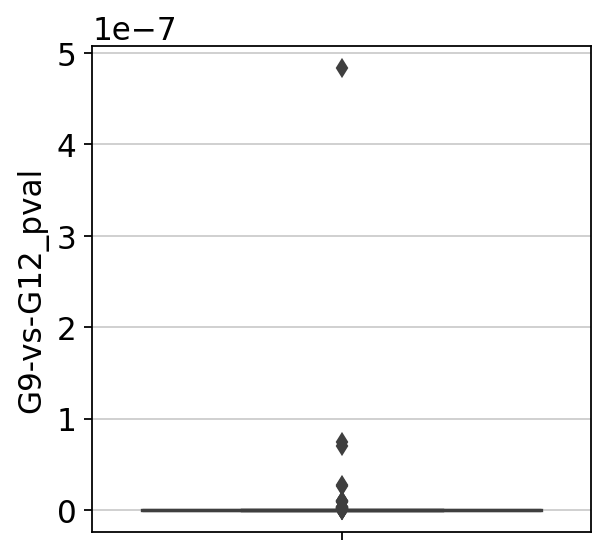

In [10]:
sns.boxplot(data=chisq_df, y='G9-vs-G12_pval')